In [1]:
%matplotlib notebook

import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from classes.Settings import Settings
from helpers.plot_functions import plot_density, plot_fragment_colored, plot_vdw_spheres
from helpers.density_helpers import calculate_no_bins, add_boundaries_per_bin
from calc_avg_fragment_2 import read_results_alignment, make_avg_fragment_if_not_exists

from helpers.density_helpers import prepare_df, find_available_volume
from helpers.geometry_helpers import (make_coordinate_df,
                                      get_vdw_distance_contact)

from sklearn.cluster import KMeans

from tqdm import tqdm
import time
import math
import copy

In [2]:
resolutions = []
# resolutions0 = np.arange(0.05, 0.1, 0.01)
# resolutions.extend(resolutions0)

resolutions1 = np.arange(0.1, 1.1, 0.1)
resolutions.extend(resolutions1)

## Other stuff

In [3]:
def make_density_plot(avg_fragment, density_df, settings):
    plotname = settings.get_density_plotname()
    fig = plt.figure()
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    ax = plot_fragment_colored(ax, avg_fragment)

    p, ax = plot_density(ax=ax, df=density_df, settings=settings)

    ax.set_title("4D density plot\n Resolution: " + str(settings.resolution))

    fig.colorbar(p)
    plt.savefig(plotname)
    plt.show()

<IPython.core.display.Javascript object>


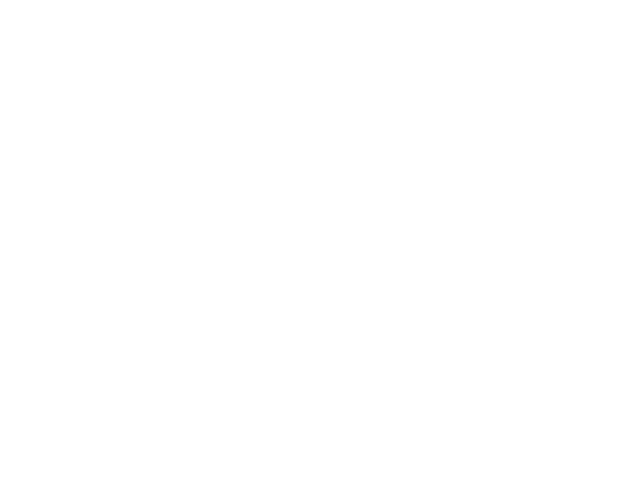

In [4]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")
settings.set_resolution(round(0.5, 2))

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
make_density_plot(avg_fragment, density_df, settings)

In [5]:
def calc_clusters(density_df, amount_of_clusters):
    to_cluster_df = density_df[density_df['to_cluster']]
    
    X = np.transpose(np.array([to_cluster_df.x_center, to_cluster_df.y_center, to_cluster_df.z_center]))

    kmeans = KMeans(n_clusters=amount_of_clusters, random_state=1)
    kmeans.fit(X)
    
    density_df.loc[density_df['to_cluster'], "cluster"] = kmeans.labels_
    
    return density_df, kmeans.cluster_centers_

In [6]:
def make_cluster_plot(avg_fragment, df, settings, centroids):
    colors = ["red", "green", "blue"]
    
    df["cluster_color"] = "grey"

    df.loc[df.cluster.notna(), "cluster_color"] = [colors[int(i)] for i in list(df.loc[df.cluster.notna(), 'cluster'])]
    df = df[df[settings.to_count_contact + "_normalized"] > 0]

    fig = plt.figure()
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    ax = plot_fragment_colored(ax, avg_fragment)
    
    greys = df[df.cluster_color == "grey"]
    rest = df[df.cluster_color != "grey"]
    
    for i, centroid in enumerate(centroids):
        volume = len(df[df.cluster == i]) * settings.resolution**3
        ax.scatter(centroid[0], centroid[1], centroid[2], s=100,\
                    label="Cluster: " + str(i+1) + " volume:" + str(volume), color=colors[i])
    
    ax.scatter(list(greys.x_center), list(greys.y_center), list(greys.z_center), s=0.1,
               color=list(greys.cluster_color), alpha=0.75)

    ax.scatter(list(rest.x_center), list(rest.y_center), list(rest.z_center),
               color=list(rest.cluster_color))

    ax.set_title("Clusters from density plot\n Resolution: " + str(settings.resolution))
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    
    ax.legend(fontsize='x-small')

    plt.show()

In [49]:
def find_bins_to_cluster(settings, fraction=0.25):
    
    density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
    print(settings.get_density_df_filename(), settings.get_density_df_key())
    
    density_df["x_center"] = density_df.xstart + 0.5 * settings.resolution
    density_df["y_center"] = density_df.ystart + 0.5 * settings.resolution
    density_df["z_center"] = density_df.zstart + 0.5 * settings.resolution
    
    # normalize
    density_df.loc[:, settings.to_count_contact + "_normalized"] =\
        density_df[settings.to_count_contact] / density_df[settings.to_count_contact].sum()

    # reset cluster color for when you run this cell again
    density_df["cluster_color"] = np.nan
    
    # set a threshold as to determine will belong to a cluster and which ones won't
    # get the upper kwartant
    max_bin = density_df[settings.to_count_contact].max()
    threshold = max_bin * fraction
    print("Threshold k-means:", threshold, "max_bin:", max_bin, "with fraction:", fraction)
  
    density_df["cluster"] = np.nan
    density_df["to_cluster"] = False
    density_df.loc[density_df[settings.to_count_contact] > threshold, 'to_cluster'] = True
    
    return density_df

RESOLUTION:  0.1
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F01


<IPython.core.display.Javascript object>


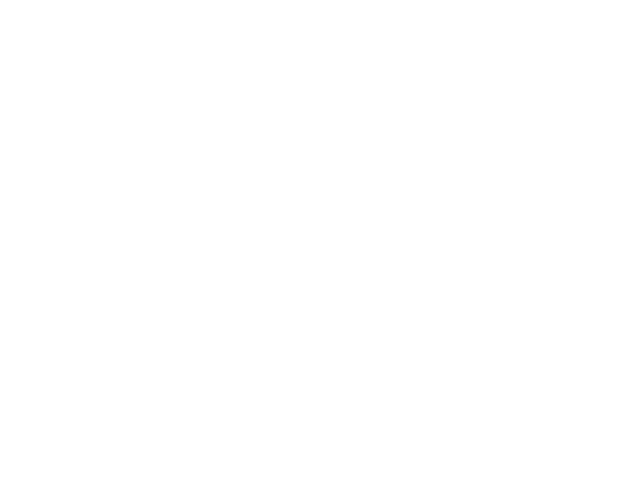

RESOLUTION:  0.2
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F02


<IPython.core.display.Javascript object>


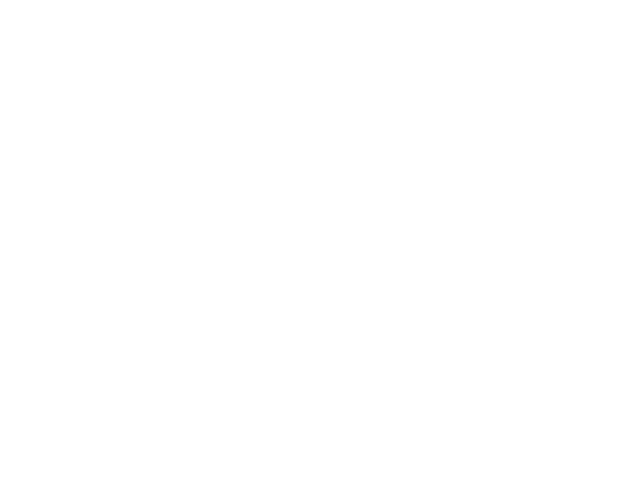

RESOLUTION:  0.3
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F03


<IPython.core.display.Javascript object>


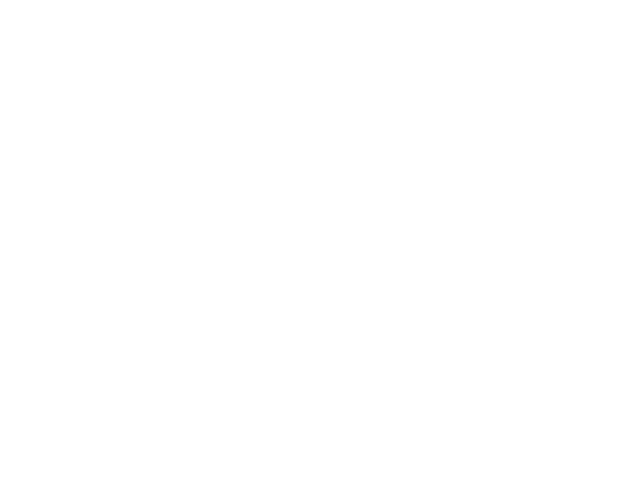

RESOLUTION:  0.4
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F04


<IPython.core.display.Javascript object>


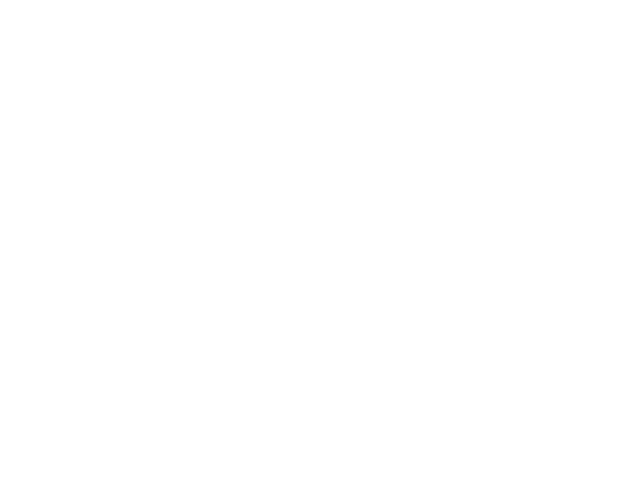

RESOLUTION:  0.5
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F05


<IPython.core.display.Javascript object>


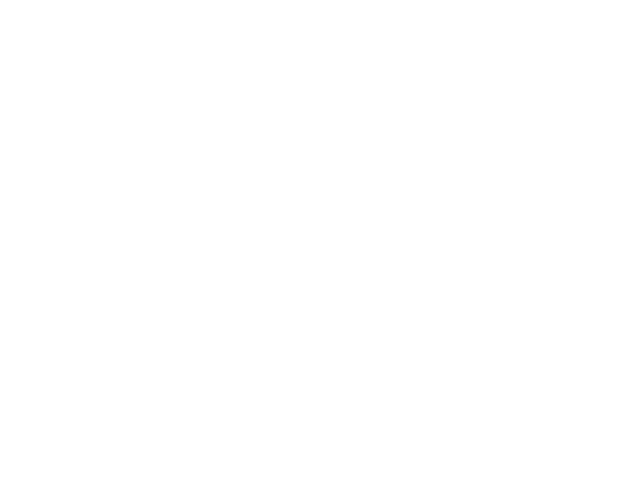

RESOLUTION:  0.6
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F06


<IPython.core.display.Javascript object>


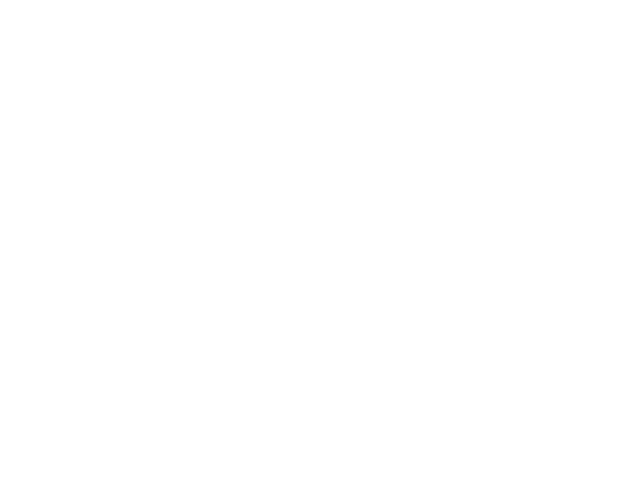

RESOLUTION:  0.7
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F07


<IPython.core.display.Javascript object>


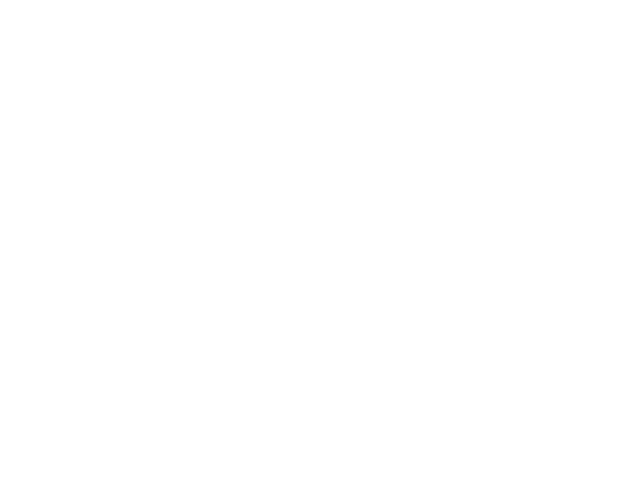

RESOLUTION:  0.8
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F08


<IPython.core.display.Javascript object>


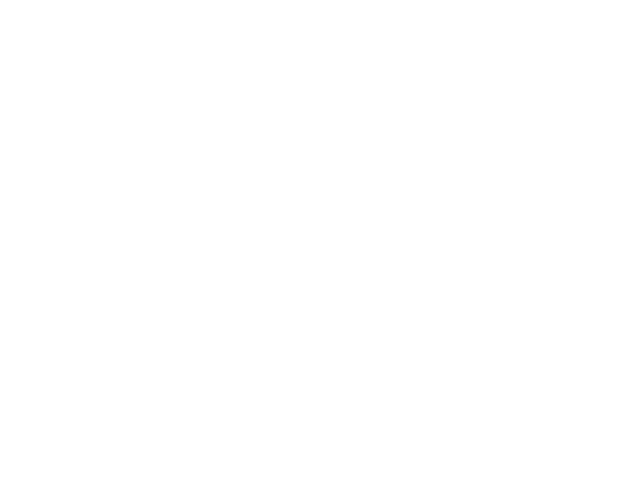

RESOLUTION:  0.9
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F09


<IPython.core.display.Javascript object>


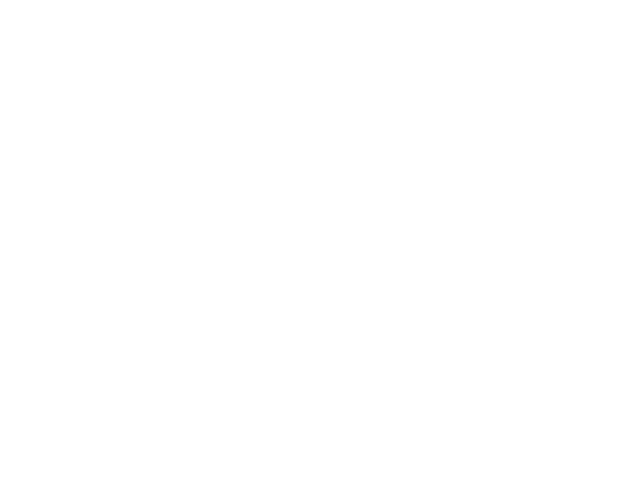

RESOLUTION:  1.0
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F1


<IPython.core.display.Javascript object>


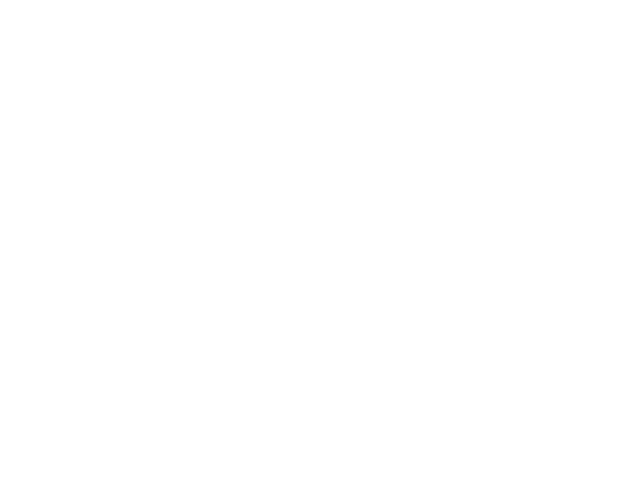

In [8]:
amount_of_clusters = 3

# set up cluster df to save all the clusters and their information in
cluster_df = pd.DataFrame(index=range(0, len(resolutions) * amount_of_clusters),\
                           columns=["resolution", "cluster_id", "centroid_x", "centroid_y", "centroid_z",\
                                    "cluster_volume", "datafraction"])

cluster_count = 0

for resolution in resolutions:
    print("RESOLUTION: ", round(resolution, 2))
    settings.set_resolution(round(resolution, 2))
    
    # work only with bins that are >0.25*maximum full
    density_df = find_bins_to_cluster(settings=settings, fraction=0.25)
        
    # calc for each bin in what cluster it belongs
    density_df, centroids = calc_clusters(density_df, amount_of_clusters)
        
    make_cluster_plot(avg_fragment, density_df, settings, centroids)
       
    for i, centroid in enumerate(centroids):
        df = density_df

        volume = len(df[df.cluster == i]) * (settings.resolution**3)
        data_fraction = df[df.cluster == i][settings.to_count_contact + "_normalized"].sum()
        
        # specific for water
        cluster_idx = 3
        
        if centroid[1] < -0.5:
            cluster_idx = 1
        elif centroid[0] > 1.5:
            cluster_idx = 2
        
        cluster_df.iloc[cluster_count] = [float(resolution), cluster_idx, centroid[0], centroid[1], centroid[2], volume, data_fraction]
        
        cluster_count +=1

<IPython.core.display.Javascript object>


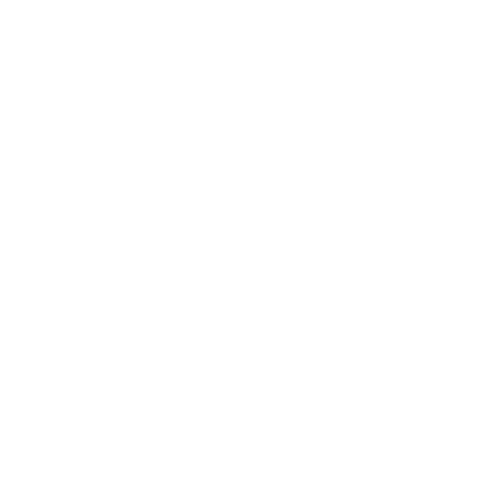

In [9]:
clusters = [[], [], []]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

plt.title("Centroid of the clusters for all resolutions")


colors = ["green", "tab:green", "fuchsia"]

for _, centroid in cluster_df.iterrows():
    ax.scatter(centroid.centroid_x, centroid.centroid_y, color=colors[int(centroid.cluster_id - 1)])
    

for _, row in avg_fragment.iterrows():
    if row.atom_symbol == "O":
        ax.scatter(row.atom_x, row.atom_y, edgecolor="black", color="red")
    else:
        ax.scatter(row.atom_x, row.atom_y, edgecolor="black", color="grey")

plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.show()

In [10]:
cluster_df = cluster_df.astype('float')
cluster_df["fraction_over_volume"] = cluster_df["datafraction"] / cluster_df["cluster_volume"]

<IPython.core.display.Javascript object>


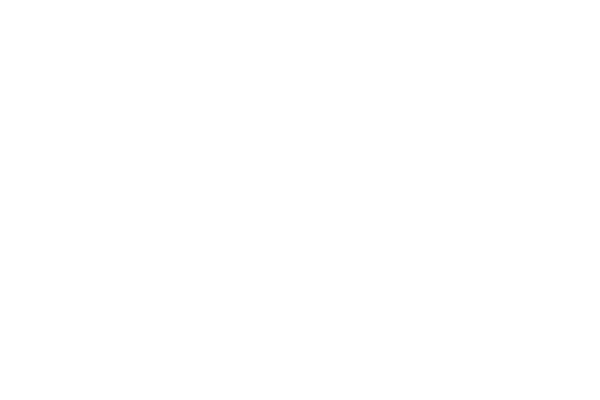

In [11]:
plt.figure(figsize=(6,4))
plt.title("Cluster volume")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].cluster_volume, 
             label="Cluster " + str(i+1),
             color=colors[i -1])

plt.xlabel("Resolution")
plt.ylabel("Volume ($\AA^{3}$)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


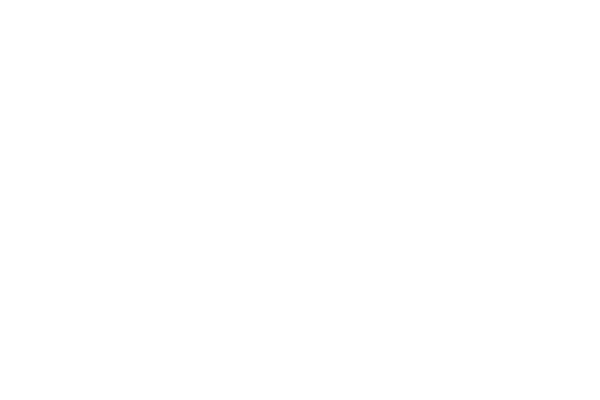

In [12]:
plt.figure(figsize=(6,4))
plt.title("Datfraction per cluster")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].datafraction,
             label="Cluster " + str(i+1),
             color=colors[i-1])

plt.legend()
plt.xlabel("Resolution")
plt.ylabel("Fraction")
plt.show()

<IPython.core.display.Javascript object>


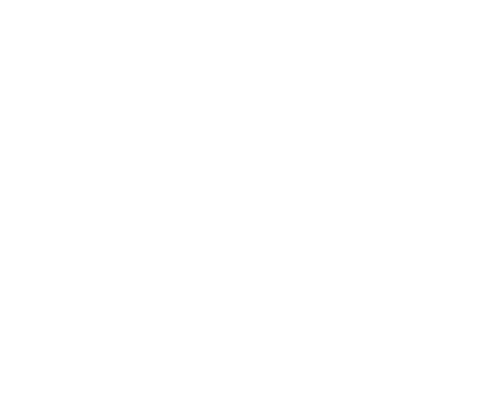

In [13]:
plt.figure(figsize=(5,4))
plt.title("Fraction over volume")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].fraction_over_volume,
             label="Cluster " + str(i+1),
             color=colors[i-1])

plt.legend()
plt.xlabel("Resolution")
plt.ylabel("Fraction over volume ($\AA^{-3}$)")
plt.show()

## H2O: CN versus CO

In [14]:
amount_of_clusters = 2

<IPython.core.display.Javascript object>


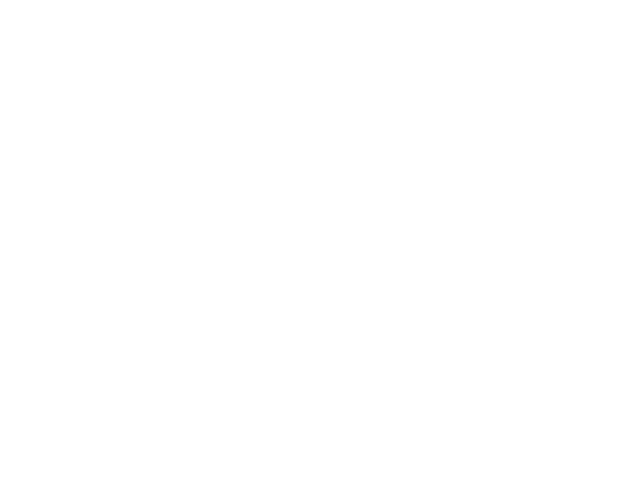

.\results\H2O\H2O_R2CO_vdw.5\H2O_R2CO_vdw.5_density.hdf O02


<IPython.core.display.Javascript object>


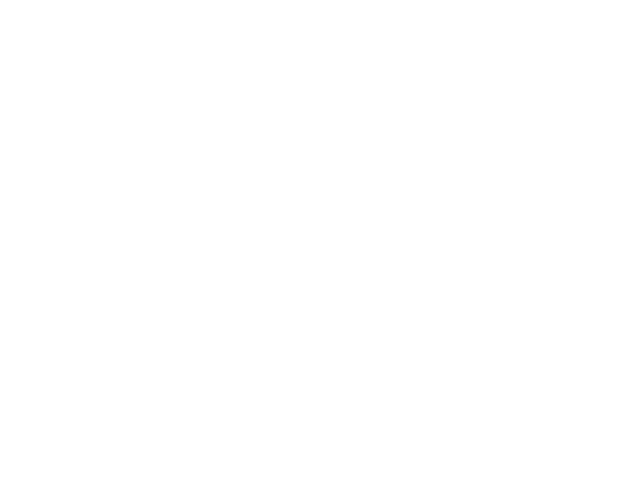

0.46400000000000013 0.1495396172606575 0.322283657889348
0.3680000000000001 0.11846486918870043 0.32191540540407715


In [15]:
settings_CO = Settings(".\\results\\H2O\\H2O_R2CO_vdw.5\\H2O_R2CO_vdw.5_aligned.csv")
settings_CO.set_atom_to_count("O")
settings_CO.set_resolution(0.2)

df_CO = read_results_alignment(settings_CO.get_aligned_csv_filename())
avg_fragment_CO = make_avg_fragment_if_not_exists(settings_CO, df_CO)

density_df_CO = pd.read_hdf(settings_CO.get_density_df_filename(), settings_CO.get_density_df_key())

make_density_plot(avg_fragment_CO, copy.copy(density_df_CO), settings_CO)


################################################################################################################


# work only with bins that are >0.25*maximum full
density_df_CO = find_bins_to_cluster(settings=settings_CO, fraction=0.1)

# calc for each bin in what cluster it belongs
cluster_df_CO, centroids_CO = calc_clusters(density_df_CO, amount_of_clusters)

make_cluster_plot(avg_fragment_CO, cluster_df_CO, settings_CO, centroids_CO)

for i, centroid in enumerate(centroids_CO):
    volume = len(density_df_CO[density_df_CO.cluster == i]) * (settings_CO.resolution**3)
    data_fraction = density_df_CO[density_df_CO.cluster == i][settings_CO.to_count_contact + "_normalized"].sum()
    
    print(volume, data_fraction, data_fraction/volume)

<IPython.core.display.Javascript object>


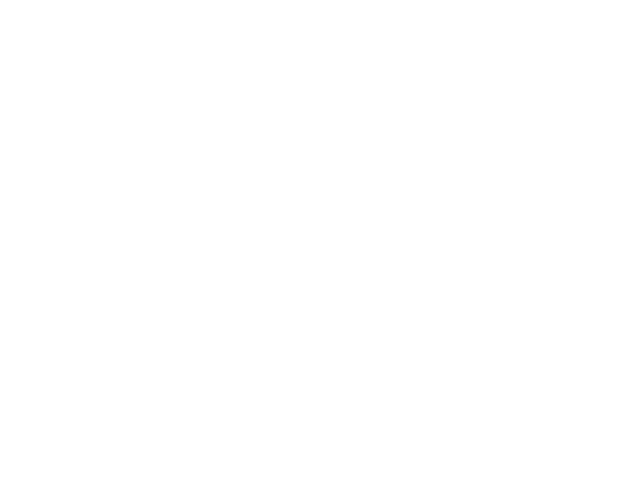

.\results\H2O\H2O_RCN_vdw.5\H2O_RCN_vdw.5_density.hdf N02


<IPython.core.display.Javascript object>


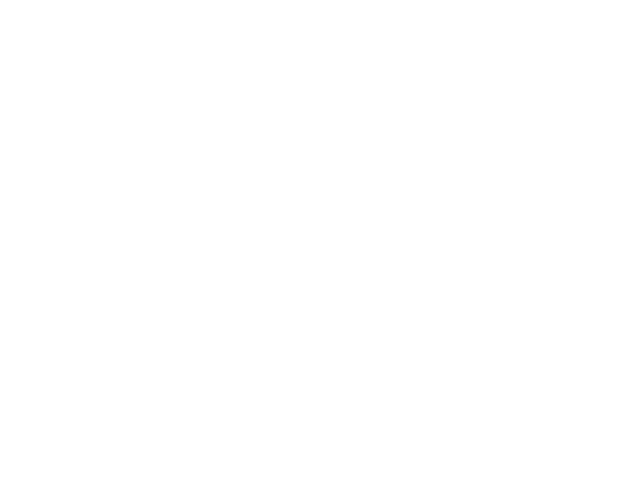

0.3680000000000001 0.1668 0.4532608695652173
0.4080000000000001 0.1392 0.3411764705882352


In [16]:
settings_CN = Settings(".\\results\\H2O\\H2O_RCN_vdw.5\\H2O_RCN_vdw.5_aligned.csv")
settings_CN.set_atom_to_count("N")
settings_CN.set_resolution(0.2)

df_CN = read_results_alignment(settings_CN.get_aligned_csv_filename())
avg_fragment_CN = make_avg_fragment_if_not_exists(settings_CN, df_CN)

density_df_CN = pd.read_hdf(settings_CN.get_density_df_filename(), settings_CN.get_density_df_key())

# density df gets normalized in plot function so give it a copy
make_density_plot(avg_fragment_CN, copy.copy(density_df_CN), settings_CN)


################################################################################################################


# work only with bins that are >0.25*maximum full
density_df_CN = find_bins_to_cluster(settings=settings_CN, fraction=0.1)

# calc for each bin in what cluster it belongs
cluster_df_CN, centroids_CN = calc_clusters(density_df_CN, amount_of_clusters)

make_cluster_plot(avg_fragment_CN, cluster_df_CN, settings_CN, centroids_CN)

for i, centroid in enumerate(centroids_CN):
    volume = len(cluster_df_CN[cluster_df_CN.cluster == i]) * (settings_CN.resolution**3)
    data_fraction = cluster_df_CN[cluster_df_CN.cluster == i][settings_CN.to_count_contact + "_normalized"].sum()
    
    print(volume, data_fraction, data_fraction/volume)

In [17]:
display(cluster_df_CO[cluster_df_CO['to_cluster']])
display(cluster_df_CN[cluster_df_CN['to_cluster']])

,xstart,ystart,zstart,O,x_center,y_center,z_center,O_normalized,cluster_color,cluster,to_cluster
17811,-2.244444,-0.094118,-0.021429,247.0,-2.144444,0.005882,0.078571,0.002148,red,0.0,True
19154,-2.048148,-0.682353,-0.214286,151.0,-1.948148,-0.582353,-0.114286,0.001313,red,0.0,True
19155,-2.048148,-0.682353,-0.021429,275.0,-1.948148,-0.582353,0.078571,0.002391,red,0.0,True
19156,-2.048148,-0.682353,0.171429,191.0,-1.948148,-0.582353,0.271429,0.001661,red,0.0,True
19157,-2.048148,-0.682353,0.364286,146.0,-1.948148,-0.582353,0.464286,0.001269,red,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
49591,2.074074,2.454902,-0.021429,335.0,2.174074,2.554902,0.078571,0.002913,green,1.0,True
49592,2.074074,2.454902,0.171429,197.0,2.174074,2.554902,0.271429,0.001713,green,1.0,True
49593,2.074074,2.454902,0.364286,156.0,2.174074,2.554902,0.464286,0.001356,green,1.0,True
50991,2.270370,2.258824,-0.021429,199.0,2.370370,2.358824,0.078571,0.001730,green,1.0,True


,xstart,ystart,zstart,N,x_center,y_center,z_center,N_normalized,cluster_color,cluster,to_cluster
9025,-2.230435,-0.676596,-0.023077,16.0,-2.130435,-0.576596,0.076923,0.002133,red,0.0,True
9050,-2.230435,-0.480851,-0.215385,12.0,-2.130435,-0.380851,-0.115385,0.001600,red,0.0,True
9051,-2.230435,-0.480851,-0.023077,34.0,-2.130435,-0.380851,0.076923,0.004533,red,0.0,True
9052,-2.230435,-0.480851,0.169231,19.0,-2.130435,-0.380851,0.269231,0.002533,red,0.0,True
9053,-2.230435,-0.480851,0.361538,13.0,-2.130435,-0.380851,0.461538,0.001733,red,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
36353,2.073913,2.651064,0.361538,11.0,2.173913,2.751064,0.461538,0.001467,green,1.0,True
37521,2.269565,2.259574,-0.023077,12.0,2.369565,2.359574,0.076923,0.001600,green,1.0,True
37547,2.269565,2.455319,-0.023077,18.0,2.369565,2.555319,0.076923,0.002400,green,1.0,True
37548,2.269565,2.455319,0.169231,14.0,2.369565,2.555319,0.269231,0.001867,green,1.0,True


In [61]:
def re_cluster(df, settings, threshold=0.1):
    amount = settings.to_count_contact
    
    unique_clusters = df.cluster.dropna().unique()

    df["new_cluster"] = np.nan
    
    fullest_bin = []
    for cluster_id in unique_clusters:
        print("Cluster id: " + str(cluster_id))
        print("Original length: " + str(len(df[df.cluster == cluster_id])))
        max_bin = df[df.cluster == cluster_id][amount].max()
        print("Max bin:" + str(max_bin))
        
        # add old bins that are full enough when using local maximum
        fraction = max_bin * threshold
        print("Fraction for this bin:", fraction)
        df.loc[((df.cluster == cluster_id) & (df[amount] > fraction)), 'new_cluster'] = cluster_id      
        print("Good enough from old: ", len(df.loc[((df.cluster == cluster_id) & (df[amount] > fraction))]))    
            
        # add bins in "x" radius around the local maximums
        new_found = True
        
        # search 1 bins further in all directions
        radius = settings.resolution
        
        # while new bins that belong to the cluster are found, keep expanding
        while new_found:
            old_length = len(df[df.new_cluster == cluster_id])
            
            for _, row in df[df.new_cluster == cluster_id].iterrows():
                df.loc[(df.x_center > row.x_center - radius) & (df.x_center < row.x_center + radius) & 
                    (df.y_center > row.y_center - radius) & (df.y_center < row.y_center + radius) &
                    (df.z_center > row.z_center - radius) & (df.z_center < row.z_center + radius) &
                    (df[amount] > fraction) & (df.new_cluster.isna()), 'new_cluster'] = cluster_id
                
            new_length = len(df[df.new_cluster == cluster_id])
                
#             maxx, maxy, maxz = df[df.new_cluster == cluster_id].x_center.max(), df[df.new_cluster == cluster_id].y_center.max(), df[df.new_cluster == cluster_id].z_center.max()
#             minx, miny, minz = df[df.new_cluster == cluster_id].x_center.min(), df[df.new_cluster == cluster_id].y_center.min(), df[df.new_cluster == cluster_id].z_center.min()
            
#             old_length = len(df[df.new_cluster == cluster_id])
            
#             df.loc[(df.x_center > minx - radius) & (df.x_center < maxx + radius) & 
#                     (df.y_center > miny - radius) & (df.y_center < maxy + radius) &
#                     (df.z_center > minz - radius) & (df.z_center < maxz + radius) &
#                     (df[amount] > fraction) & (df.new_cluster.isna()), 'new_cluster'] = cluster_id
            
#             new_length = len(df[df.new_cluster == cluster_id])
            
            print(old_length, new_length)
                        
            if new_length <= old_length:
                new_found = False
        
        print("New length: " + str(new_length) + "\n\n")
        
    return df

Cluster id: 0.0
Original length: 58
Max bin:0.011311764757027467
New length: 58


Cluster id: 1.0
Original length: 46
Max bin:0.005834123099127925
New length: 88


         xstart    ystart    zstart       O  x_center  y_center  z_center  \
19239 -2.048148 -0.094118 -0.021429  1301.0 -1.948148  0.005882  0.078571   

       O_normalized cluster_color  cluster  to_cluster  new_cluster  
19239      0.011312           red      0.0        True          0.0  


,xstart,ystart,zstart,O,x_center,y_center,z_center,O_normalized,cluster_color,cluster,to_cluster,new_cluster
17811,-2.244444,-0.094118,-0.021429,247.0,-2.144444,0.005882,0.078571,0.002148,red,0.0,True,0.0
19154,-2.048148,-0.682353,-0.214286,151.0,-1.948148,-0.582353,-0.114286,0.001313,red,0.0,True,0.0
19155,-2.048148,-0.682353,-0.021429,275.0,-1.948148,-0.582353,0.078571,0.002391,red,0.0,True,0.0
19156,-2.048148,-0.682353,0.171429,191.0,-1.948148,-0.582353,0.271429,0.001661,red,0.0,True,0.0
19157,-2.048148,-0.682353,0.364286,146.0,-1.948148,-0.582353,0.464286,0.001269,red,0.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49591,2.074074,2.454902,-0.021429,335.0,2.174074,2.554902,0.078571,0.002913,green,1.0,True,1.0
49592,2.074074,2.454902,0.171429,197.0,2.174074,2.554902,0.271429,0.001713,green,1.0,True,1.0
49593,2.074074,2.454902,0.364286,156.0,2.174074,2.554902,0.464286,0.001356,green,1.0,True,1.0
50991,2.270370,2.258824,-0.021429,199.0,2.370370,2.358824,0.078571,0.001730,green,1.0,True,1.0


<IPython.core.display.Javascript object>


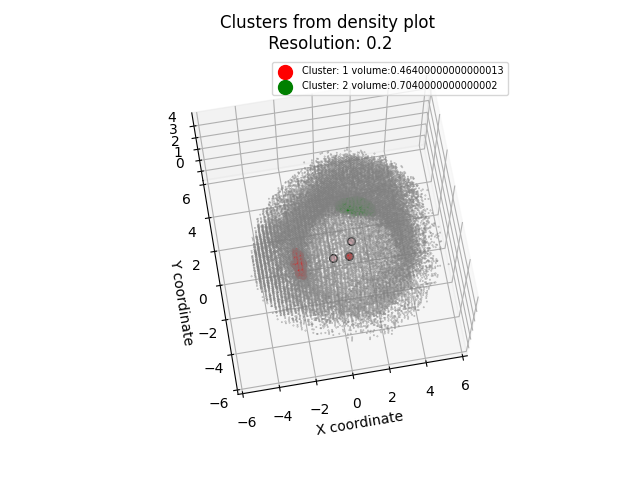

0.0
0.46400000000000013 0.1495396172606575 0.322283657889348
1.0
0.7040000000000002 0.15201759801065967 0.21593408808332334


In [27]:
reclustered_CO = re_cluster(cluster_df_CO, settings_CO)

print(reclustered_CO[reclustered_CO.O_normalized == reclustered_CO.O_normalized.max()])
display(reclustered_CO[reclustered_CO['to_cluster']])

density_df_CO_new = copy.copy(reclustered_CO)
density_df_CO_new['cluster'] = density_df_CO_new['new_cluster']

make_cluster_plot(avg_fragment_CO, density_df_CO_new, settings_CO, centroids_CO)

unique_clusters = density_df_CO_new.cluster.dropna().unique()

for cluster_id in unique_clusters:
    print(cluster_id)
    volume = len(density_df_CO_new[density_df_CO_new.cluster == cluster_id]) * (settings_CO.resolution**3)
    data_fraction = density_df_CO_new[density_df_CO_new.cluster == cluster_id][settings_CO.to_count_contact + "_normalized"].sum()
    
    print(volume, data_fraction, data_fraction/volume)

Cluster id: 0.0
Original length: 46
Max bin:0.0124
New length: 46


Cluster id: 1.0
Original length: 51
Max bin:0.007866666666666666
New length: 87


         xstart    ystart    zstart     N  x_center  y_center  z_center  \
10325 -2.034783 -0.089362 -0.023077  93.0 -1.934783  0.010638  0.076923   

       N_normalized cluster_color  cluster  to_cluster  new_cluster  
10325        0.0124           red      0.0        True          0.0  


,xstart,ystart,zstart,N,x_center,y_center,z_center,N_normalized,cluster_color,cluster,to_cluster,new_cluster
9025,-2.230435,-0.676596,-0.023077,16.0,-2.130435,-0.576596,0.076923,0.002133,red,0.0,True,0.0
9050,-2.230435,-0.480851,-0.215385,12.0,-2.130435,-0.380851,-0.115385,0.001600,red,0.0,True,0.0
9051,-2.230435,-0.480851,-0.023077,34.0,-2.130435,-0.380851,0.076923,0.004533,red,0.0,True,0.0
9052,-2.230435,-0.480851,0.169231,19.0,-2.130435,-0.380851,0.269231,0.002533,red,0.0,True,0.0
9053,-2.230435,-0.480851,0.361538,13.0,-2.130435,-0.380851,0.461538,0.001733,red,0.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36353,2.073913,2.651064,0.361538,11.0,2.173913,2.751064,0.461538,0.001467,green,1.0,True,1.0
37521,2.269565,2.259574,-0.023077,12.0,2.369565,2.359574,0.076923,0.001600,green,1.0,True,1.0
37547,2.269565,2.455319,-0.023077,18.0,2.369565,2.555319,0.076923,0.002400,green,1.0,True,1.0
37548,2.269565,2.455319,0.169231,14.0,2.369565,2.555319,0.269231,0.001867,green,1.0,True,1.0


c:\users\natas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


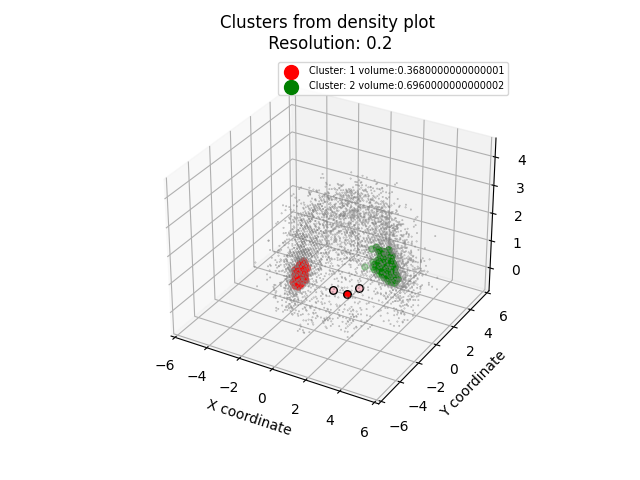

0.0
0.3680000000000001 0.1668 0.4532608695652173
1.0
0.6960000000000002 0.17199999999999996 0.24712643678160906


In [20]:
reclustered_CN = re_cluster(cluster_df_CN, settings_CN)

print(reclustered_CN[reclustered_CN.N_normalized == reclustered_CN.N_normalized.max()])
display(reclustered_CN[reclustered_CN['to_cluster']])

density_df_CN_new = copy.copy(reclustered_CN)
density_df_CN_new['cluster'] = density_df_CN_new['new_cluster']

make_cluster_plot(avg_fragment_CN, density_df_CN_new, settings_CN, centroids_CN)

unique_clusters = density_df_CN_new.cluster.dropna().unique()

for cluster_id in unique_clusters:
    print(cluster_id)
    volume = len(density_df_CN_new[density_df_CN_new.cluster == cluster_id]) * (settings_CN.resolution**3)
    data_fraction = density_df_CN_new[density_df_CN_new.cluster == cluster_id][settings_CN.to_count_contact + "_normalized"].sum()
    
    print(volume, data_fraction, data_fraction/volume)

In [21]:
# find the volume of the central group
tolerance = 0.5

coordinate_df_CO = make_coordinate_df(df_CO, settings_CO, avg_fragment_CO)
coordinate_df_CN = make_coordinate_df(df_CN, settings_CN, avg_fragment_CN)

contact_radius_CO = get_vdw_distance_contact(coordinate_df_CO, settings_CO)
contact_radius_CN = get_vdw_distance_contact(coordinate_df_CN, settings_CN)

volume_CO = find_available_volume(avg_fragment=avg_fragment_CO, extra=(tolerance + contact_radius_CO))
volume_CN = find_available_volume(avg_fragment=avg_fragment_CN, extra=(tolerance + contact_radius_CN))

print(volume_CO, volume_CN)

190.70000000000005 196.04100000000003


In [22]:
print('CO')
print('Method, Cluster ID, Volume, DataFraction Datafraction/Volume')
for cluster_id in unique_clusters:
   
    volume = len(density_df_CO[density_df_CO.cluster == cluster_id]) * (settings_CO.resolution**3)
    data_fraction = density_df_CO[density_df_CO.cluster == cluster_id][settings_CO.to_count_contact + "_normalized"].sum()
    
    print('old', cluster_id,  round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * volume_CO,4))

print()
for cluster_id in unique_clusters:
    volume = len(density_df_CO_new[density_df_CO_new.cluster == cluster_id]) * (settings_CO.resolution**3)
    data_fraction = density_df_CO_new[density_df_CO_new.cluster == cluster_id][settings_CO.to_count_contact + "_normalized"].sum()
    
    print('new', cluster_id, round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * volume_CO,4))
    


CO
Method, Cluster ID, Volume, DataFraction Datafraction/Volume
old 0.0 0.464 0.1495 0.3223 61.4595
old 1.0 0.368 0.1185 0.3219 61.3893

new 0.0 0.464 0.1495 0.3223 61.4595
new 1.0 0.704 0.152 0.2159 41.1786


In [23]:
print('CN')
print('Method, Cluster ID, Volume, DataFraction Datafraction/Volume')
for cluster_id in unique_clusters:
   
    volume = len(density_df_CN[density_df_CN.cluster == cluster_id]) * (settings_CN.resolution**3)
    data_fraction = density_df_CN[density_df_CN.cluster == cluster_id][settings_CN.to_count_contact + "_normalized"].sum()
    
    print('old', cluster_id, round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * volume_CN,4))

print()
for cluster_id in unique_clusters:
    volume = len(density_df_CN_new[density_df_CN_new.cluster == cluster_id]) * (settings_CN.resolution**3)
    data_fraction = density_df_CN_new[density_df_CN_new.cluster == cluster_id][settings_CN.to_count_contact + "_normalized"].sum()
    
    print('new', cluster_id, round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * volume_CN,4))
    


CN
Method, Cluster ID, Volume, DataFraction Datafraction/Volume
old 0.0 0.368 0.1668 0.4533 88.8577
old 1.0 0.408 0.1392 0.3412 66.8846

new 0.0 0.368 0.1668 0.4533 88.8577
new 1.0 0.696 0.172 0.2471 48.4469


In [24]:
def do_everything(filename):
    pass
# cluster
# recluster
# analyze
    

## H2O: CF

In [25]:
amount_of_clusters = 3

<IPython.core.display.Javascript object>


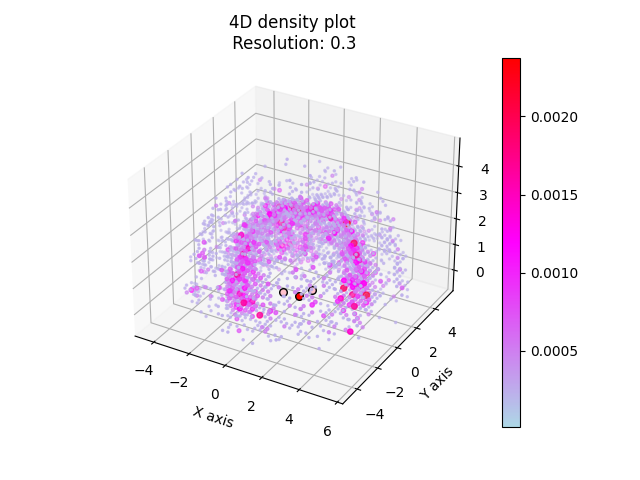



Cluster
.\results\H2O\H2O_CF_vdw.5\H2O_CF_vdw.5_density.hdf F03
Threshold k-means: 2.5 max_bin: 10.0 with fraction: 0.25


<IPython.core.display.Javascript object>


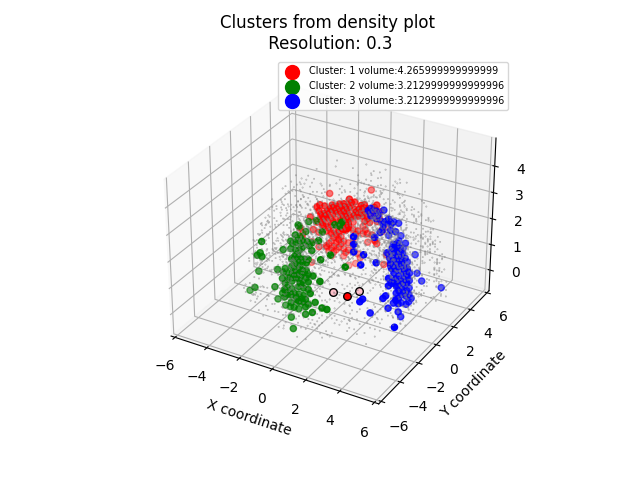

4.265999999999999 0.13857855954361778 0.03248442558453301
3.2129999999999996 0.1000713097218921 0.031145754659785904
3.2129999999999996 0.10862847634894225 0.033809049595064505
             xstart        ystart        zstart             F      x_center  \
count  23275.000000  23275.000000  23275.000000  23275.000000  23275.000000   
mean       0.454286      0.154286      1.957895      0.180752      0.604286   
std        2.943347      2.943347      1.556719      0.619378      2.943348   
min       -4.500000     -4.800000     -0.600000      0.000000     -4.350000   
25%       -2.168571     -2.468571      0.536842      0.000000     -2.018571   
50%        0.454286      0.154286      1.957895      0.000000      0.604286   
75%        3.077143      2.777143      3.378947      0.000000      3.227143   
max        5.408571      5.108572      4.515790     10.000000      5.558571   

           y_center      z_center  F_normalized  cluster_color     cluster  
count  23275.000000  23275.000000 

<IPython.core.display.Javascript object>


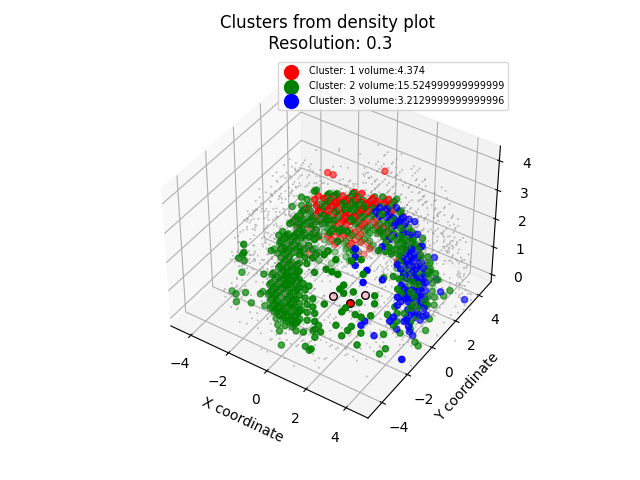

In [62]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")
settings.set_resolution(round(0.3, 2))

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())

# density df gets normalized in plot function so give it a copy
make_density_plot(avg_fragment, copy.copy(density_df), settings)

################################################################################################################
# Cluster
################################################################################################################

print("\n\nCluster")
# work only with bins that are >0.25*maximum full
density_df = find_bins_to_cluster(settings=settings, fraction=0.25)

# calc for each bin in what cluster it belongs
cluster_df, centroids = calc_clusters(density_df, amount_of_clusters)

make_cluster_plot(avg_fragment, copy.copy(cluster_df), settings, centroids)

for i, centroid in enumerate(centroids):
    volume = len(cluster_df[cluster_df.cluster == i]) * (settings.resolution**3)
    data_fraction = cluster_df[cluster_df.cluster == i][settings.to_count_contact + "_normalized"].sum()
    
    print(volume, data_fraction, data_fraction/volume)
    

################################################################################################################
# Recluster
################################################################################################################ 

print(cluster_df.describe())

print("\n\nRecluster")
reclustered = re_cluster(cluster_df, settings, threshold=0.2)

density_df_new = copy.copy(reclustered)

# copy new cluster into cluster because cluster plot uses 'cluster'
density_df_new['cluster'] = density_df_new['new_cluster']

make_cluster_plot(avg_fragment, density_df_new, settings, centroids)

# unique_clusters = density_df_new.cluster.dropna().unique()

# for cluster_id in unique_clusters:
#     print(cluster_id)
#     volume = len(density_df_CN_new[density_df_new.cluster == cluster_id]) * (settings.resolution**3)
#     data_fraction = density_df_new[density_df_new.cluster == cluster_id][settings.to_count_contact + "_normalized"].sum()
    
#     print(volume, data_fraction, data_fraction/volume)